In [1]:
import numpy as np
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches

### Calculating cross-region structure-function coupling

In [2]:
# Read sc and fc

sc_matrices = []
for root, dirs, files in os.walk(r"D:\Download\SFC\SFC_HCP\3_Modeling\2_modeling\sc_dataset\raw"):
    for file in files:
        path_sc = os.path.join(root, file)
        sc_matrices.append(np.load(path_sc))
sc_matrices = np.array(sc_matrices)

fc_matrices = []
for root, dirs, files in os.walk(r"D:\Download\SFC\SFC_HCP\3_Modeling\2_modeling\fc_dataset\raw"):
    for file in files:
        path_fc = os.path.join(root, file)
        fc_matrices.append(np.load(path_fc))
fc_matrices = np.array(fc_matrices)

In [3]:
sc = sc_matrices.mean(axis=0)
fc = fc_matrices.mean(axis=0)

In [4]:
# Calculating cross-region sfc

def compute_correlation_matrix_corrcoef(A, B):
    combined = np.vstack([A, B])
    full_corr = np.corrcoef(combined)
    n = A.shape[0]
    corr_matrix = full_corr[:n, n:n*2]
    return corr_matrix

sfc_matrix = compute_correlation_matrix_corrcoef(sc, fc)

In [5]:
# Reorder by network

tab = pd.read_excel(r"D:\Download\SFC\SFC_HCP\1_Source\A Whole-Cortex Probabilistic Diffusion\A Whole-Cortex Probabilistic Diffusion\allTables.xlsx", sheet_name="table 2")
transf = pd.concat([tab.iloc[:, [0, 2]], tab.iloc[:, [4, 6]].rename(columns={'Idx..1':'Idx.', 'Orig..1':'Orig.'}), tab.iloc[:, [8, 10]].rename(columns={'Idx..2':'Idx.', 'Orig..2':'Orig.'})], axis=0)
transf = transf.sort_values(by='Orig.').reset_index(drop=True)
sfc_matrix_network = np.zeros_like(sfc_matrix)
for i in range(360):
    for j in range(360):
        y = transf.iloc[i, 0]-1 if i < 180 else transf.iloc[i-180, 0]-1+180
        x = transf.iloc[j, 0]-1 if j < 180 else transf.iloc[j-180, 0]-1+180
        sfc_matrix_network[y, x] = sfc_matrix[i, j]

In [6]:
np.save('D:\\Download\\sfc_whole_corr.npy', sfc_matrix_network)

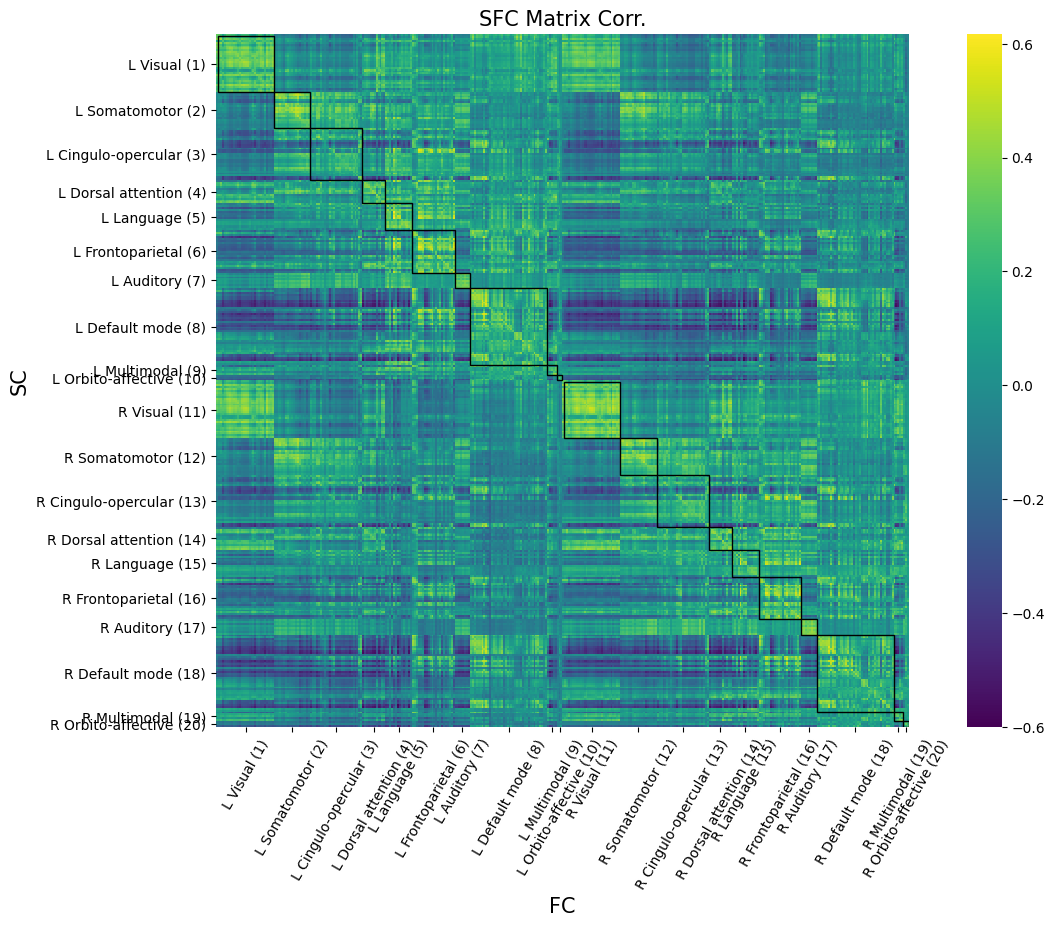

In [11]:
plt.figure(figsize=(15, 9))
sns.heatmap(sfc_matrix_network, annot=False, cmap='viridis',
            square=True, xticklabels=False,
            yticklabels=False)
plt.title('SFC Matrix Corr.', size=15)

ax = plt.gca()

boundaries = [
    [1, 30],
    [30, 49],
    [49, 76],
    [76, 88],
    [88, 102],
    [102, 124],
    [124, 132],
    [132, 172],
    [172, 177],
    [177, 180],
    [1+180, 30+180],
    [30+180, 49+180],
    [49+180, 76+180],
    [76+180, 88+180],
    [88+180, 102+180],
    [102+180, 124+180],
    [124+180, 132+180],
    [132+180, 172+180],
    [172+180, 177+180],
    [177+180, 180+180]
]

for boundary in boundaries:
    start, end = boundary
    width = end - start
    height = end - start
    
    rect = patches.Rectangle(
        (start, start), 
        width, height,
        linewidth=1, 
        edgecolor='black', 
        facecolor='none'
    )
    
    ax.add_patch(rect)

plt.ylabel('SC', size=15)
plt.yticks([(i[0]+i[1])/2 for i in boundaries],
           ['L Visual (1)', 'L Somatomotor (2)', 'L Cingulo-opercular (3)', 'L Dorsal attention (4)', 'L Language (5)',
            'L Frontoparietal (6)', 'L Auditory (7)', 'L Default mode (8)', 'L Multimodal (9)', 'L Orbito-affective (10)',
            'R Visual (11)', 'R Somatomotor (12)', 'R Cingulo-opercular (13)', 'R Dorsal attention (14)', 'R Language (15)',
            'R Frontoparietal (16)', 'R Auditory (17)', 'R Default mode (18)', 'R Multimodal (19)', 'R Orbito-affective (20)'])

plt.xlabel('FC', size=15)
plt.xticks([(i[0]+i[1])/2 for i in boundaries],
           ['L Visual (1)', 'L Somatomotor (2)', 'L Cingulo-opercular (3)', 'L Dorsal attention (4)', 'L Language (5)',
            'L Frontoparietal (6)', 'L Auditory (7)', 'L Default mode (8)', 'L Multimodal (9)', 'L Orbito-affective (10)',
            'R Visual (11)', 'R Somatomotor (12)', 'R Cingulo-opercular (13)', 'R Dorsal attention (14)', 'R Language (15)',
            'R Frontoparietal (16)', 'R Auditory (17)', 'R Default mode (18)', 'R Multimodal (19)', 'R Orbito-affective (20)'],
           rotation=60)

plt.savefig('D:\\Download\\sfc_matrix_corr.png', dpi=600, pad_inches=0.0,
           bbox_inches='tight')

### Calculating the structure-function coupling of individuals for contrast

In [12]:
def row_wise_correlation(matrix1, matrix2):
    matrix1_centered = matrix1 - matrix1.mean(axis=1, keepdims=True)
    matrix2_centered = matrix2 - matrix2.mean(axis=1, keepdims=True)
    numerator = np.sum(matrix1_centered * matrix2_centered, axis=1)
    denominator = np.sqrt(
        np.sum(matrix1_centered**2, axis=1) * 
        np.sum(matrix2_centered**2, axis=1)
    ) + 1e-7
    correlation = numerator / denominator
    correlation[denominator <= 1e-7] = 0
    return correlation

In [13]:
corr_sfc = np.zeros((3992, 360))
for i in range(998):
    sc = sc_matrices[i]
    for j in range(4):
        fc = fc_matrices[4*i+j]
        corr_sfc[4*i+j] = row_wise_correlation(sc, fc)

In [16]:
import pandas as pd

vgcl_sfc = pd.read_csv(r"D:\Download\SFC\SFC_HCP\6_Prediction\VGCL_individual_sfc.csv")

In [21]:
corr_sfc_new = vgcl_sfc.copy()
corr_sfc_new.iloc[:, 3:] = corr_sfc

In [24]:
corr_sfc_new.to_csv('D:\\Download\\corr_individual_sfc.csv', index=False)